In [3]:
from pyforestscan.calculate import calculate_chm, calculate_fhd, assign_voxels
from pyforestscan.handlers import read_lidar, create_geotiff
import numpy as np
import glob, os

In [4]:
path = "/home/mgallet/Documents/DATA/LIDAR_TEST/processed/lidar_data/Belledonne/**/*.npy"
path2 = "/home/mgallet/Documents/DATA/LIDAR_TEST/processed_V2_*/**/*.npy"

In [5]:
data = np.load(glob.glob(path, recursive=True)[0])

In [7]:
data

array([( 943029.54, 6471467.59, 1639.7 , 44847, 2, 0.        ),
       ( 943025.88, 6471467.77, 1637.86, 41898, 2, 0.        ),
       ( 943026.8 , 6471467.59, 1638.24, 48015, 2, 0.        ), ...,
       (1002789.71, 6550006.35, 1726.2 ,  1107, 2, 0.        ),
       (1002769.25, 6550001.95, 1743.2 ,  1196, 5, 2.66449168),
       (1002762.35, 6550005.71, 1746.36,  1161, 2, 0.        )],
      shape=(559104190,), dtype=[('X', '<f8'), ('Y', '<f8'), ('Z', '<f8'), ('Intensity', '<u2'), ('Classification', 'u1'), ('HeightAboveGround', '<f8')])

In [ ]:
voxel_resolution = (20, 20, 0.1)
voxels, extent = assign_voxels(data, voxel_resolution)

chm = calculate_chm(data, voxel_resolution, interpolation=None)



In [ ]:
import numpy as np
import rasterio
from rasterio.transform import from_origin
from joblib import Parallel, delayed
from tqdm import tqdm

def compute_chm(points, resolution=1.0, quantile=100,  output_tif=None):
    # Extraire les colonnes
    x = points['X']
    y = points['Y']
    z = points['HeightAboveGround']  # ou points['Z'] si vous n'avez pas HeightAboveGround

    # Définir l’étendue
    xmin, xmax = np.min(x), np.max(x)
    ymin, ymax = np.min(y), np.max(y)

    width = int(np.ceil((xmax - xmin) / resolution))
    height = int(np.ceil((ymax - ymin) / resolution))

    # Convertir coordonnées XY en indices de grille
    col = ((x - xmin) / resolution).astype(int)
    row = ((ymax - y) / resolution).astype(int)  # attention à l'inversion Y

    # Grouper les points par cellule
    from collections import defaultdict
    grid_dict = defaultdict(list)
    for r, c, val in zip(row, col, z):
        grid_dict[(r, c)].append(val)

    # Fonction pour calculer le quantile sur une cellule
    def process_cell(cell):
        r, c = cell
        values = grid_dict[(r, c)]
        return (r, c, np.nanquantile(values, quantile / 100.0))

    # Parallélisation
    cells = list(grid_dict.keys())
    results = Parallel(n_jobs=-1)(delayed(process_cell)(cell) for cell in tqdm(cells))

    # Créer la grille CHM
    chm = np.full((height, width), np.nan, dtype=np.float32)
    for r, c, val in results:
        chm[r, c] = val

    # Export GeoTIFF
    if output_tif:
        transform = from_origin(xmin, ymax, resolution, resolution)
        with rasterio.open(
            output_tif, 'w',
            driver='GTiff',
            height=chm.shape[0],
            width=chm.shape[1],
            count=1,
            dtype=chm.dtype,
            crs='EPSG:2154',  # ou ajustez selon votre système de coordonnées
            transform=transform,
            nodata=np.nan
        ) as dst:
            dst.write(chm, 1)

    return chm

# Exemple d'utilisation
# chm = compute_chm(mon_array, resolution=1.0, quantile=95, classification_filter=[5], output_tif="chm_95.tif")


In [ ]:
import numpy as np
import rasterio
from rasterio.transform import from_origin
from joblib import Parallel, delayed
from tqdm import tqdm

def compute_fhd(points, resolution=1.0, alti_resolution=1.0, output_tif=None):
    x = points['X']
    y = points['Y']
    z = points['HeightAboveGround']


    # Étendue spatiale
    xmin, xmax = np.min(x), np.max(x)
    ymin, ymax = np.min(y), np.max(y)
    width = int(np.ceil((xmax - xmin) / resolution))
    height = int(np.ceil((ymax - ymin) / resolution))

    # Indices grille
    col = ((x - xmin) / resolution).astype(int)
    row = ((ymax - y) / resolution).astype(int)

    # Groupement par cellule
    from collections import defaultdict
    grid_dict = defaultdict(list)
    for r, c, h in zip(row, col, z):
        grid_dict[(r, c)].append(h)

    # Fonction pour calculer la FHD sur une cellule
    def compute_cell_fhd(cell):
        r, c = cell
        heights = grid_dict[(r, c)]
        if len(heights) == 0:
            return (r, c, np.nan)
        # Binning
        bins = np.arange(0, max(heights)+alti_resolution, alti_resolution)
        hist, _ = np.histogram(heights, bins=bins)
        probs = hist / np.sum(hist)
        probs = probs[probs > 0]
        fhd = -np.sum(probs * np.log(probs))
        return (r, c, fhd)

    # Parallélisation
    cells = list(grid_dict.keys())
    results = Parallel(n_jobs=-1)(delayed(compute_cell_fhd)(cell) for cell in tqdm(cells))

    # Création raster FHD
    fhd_raster = np.full((height, width), np.nan, dtype=np.float32)
    for r, c, val in results:
        fhd_raster[r, c] = val

    # Export GeoTIFF
    if output_tif:
        transform = from_origin(xmin, ymax, resolution, resolution)
        with rasterio.open(
            output_tif, 'w',
            driver='GTiff',
            height=fhd_raster.shape[0],
            width=fhd_raster.shape[1],
            count=1,
            dtype=fhd_raster.dtype,
            crs='EPSG:2154',  # ajustez selon votre système de coordonnées
            transform=transform,
            nodata=np.nan
        ) as dst:
            dst.write(fhd_raster, 1)

    return fhd_raster

# Exemple d'utilisation
# fhd = compute_fhd(mon_array, resolution=1.0, classification_filter=[5], bin_size=1.0, output_tif="fhd.tif")


In [ ]:
import numpy as np
from joblib import Parallel, delayed
from collections import defaultdict
from tqdm import tqdm

def compute_chm_fhd_canal(points, resolution=1.0, classification_filter=[5], 
                          seuils_chm=[0.2, 2.0], bin_size=1.0):
    x = points['X']
    y = points['Y']
    z = points['HeightAboveGround']
    classification = points['Classification']

    # Filtrage
    mask = np.isin(classification, classification_filter)
    x, y, z = x[mask], y[mask], z[mask]

    # Dimensions grille
    xmin, xmax = np.min(x), np.max(x)
    ymin, ymax = np.min(y), np.max(y)
    width = int(np.ceil((xmax - xmin) / resolution))
    height = int(np.ceil((ymax - ymin) / resolution))

    # Index grille
    col = ((x - xmin) / resolution).astype(int)
    row = ((ymax - y) / resolution).astype(int)

    # Groupement par cellule
    grid_dict = defaultdict(list)
    for r, c, h in zip(row, col, z):
        grid_dict[(r, c)].append(h)

    # Calcul CHM et FHD pour chaque cellule
    def compute_cell_values(cell):
        r, c = cell
        heights = grid_dict[(r, c)]
        if not heights:
            return (r, c, np.nan, np.nan)

        heights = np.array(heights)
        chm = np.nanquantile(heights, 1.0)  # quantile 100%
        bins = np.arange(0, heights.max() + bin_size, bin_size)
        hist, _ = np.histogram(heights, bins=bins)
        probs = hist / np.sum(hist)
        probs = probs[probs > 0]
        fhd = -np.sum(probs * np.log(probs)) if len(probs) > 0 else 0.0

        return (r, c, chm, fhd)

    cells = list(grid_dict.keys())
    results = Parallel(n_jobs=-1)(delayed(compute_cell_values)(cell) for cell in tqdm(cells))

    # Matrices
    chm = np.full((height, width), np.nan, dtype=np.float32)
    fhd = np.full_like(chm, np.nan)
    canal = np.full_like(chm, 127, dtype=np.uint8)  # par défaut: nan

    # Remplissage
    seuil_bas, seuil_haut = seuils_chm
    for r, c, chm_val, fhd_val in results:
        chm[r, c] = chm_val
        fhd[r, c] = fhd_val

        if np.isnan(chm_val) or np.isnan(fhd_val):
            canal[r, c] = 127  # NaN
        elif chm_val == 0 and fhd_val == 0:
            canal[r, c] = 0
        elif 0 < chm_val <= seuil_bas:
            canal[r, c] = 1
        elif chm_val > seuil_haut:
            canal[r, c] = 2
        else:
            canal[r, c] = 0  # autres cas

    return canal


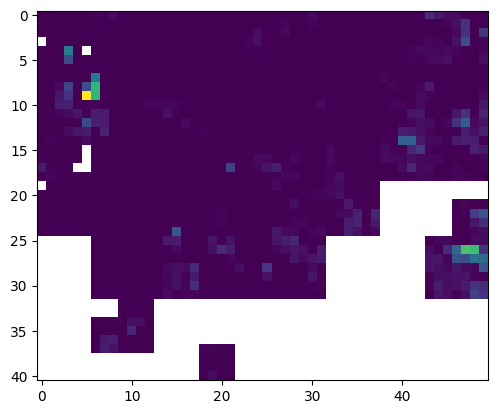

In [18]:
from matplotlib import pyplot as plt
plt.imshow(chm[0], cmap="viridis")

In [9]:

create_geotiff(chm[0], "chm.tif", "EPSG:2154", extent)


In [12]:
fhd = calculate_fhd(voxels)
create_geotiff(fhd, "fhd.tif", "EPSG:2154", extent)

In [ ]:
voxels, extent = assign_voxels(data, voxel_resolution)
fhd = calculate_fhd(data, voxel_resolution)
create_geotiff(fhd, "fhd.tif", "EPSG:2154", extent)
del voxels

chm = calculate_chm(data, voxel_resolution, interpolation=None)
create_geotiff(chm, "chm.tif", "EPSG:2154", extent)

In [ ]:
import numpy as np
import rasterio
from rasterio.transform import from_origin
from joblib import Parallel, delayed
from collections import defaultdict
from tqdm import tqdm

def compute_chm_fhd_and_canal(points, resolution=1.0, classification_filter=[5],
                               quantile=100, bin_size=1.0, seuils_chm=[0.2, 2.0]):
    x = points['X']
    y = points['Y']
    z = points['HeightAboveGround']
    classification = points['Classification']

    # Filtrage
    mask = np.isin(classification, classification_filter)
    x, y, z = x[mask], y[mask], z[mask]

    xmin, xmax = np.min(x), np.max(x)
    ymin, ymax = np.min(y), np.max(y)
    width = int(np.ceil((xmax - xmin) / resolution))
    height = int(np.ceil((ymax - ymin) / resolution))

    col = ((x - xmin) / resolution).astype(int)
    row = ((ymax - y) / resolution).astype(int)

    grid_dict = defaultdict(list)
    for r, c, h in zip(row, col, z):
        grid_dict[(r, c)].append(h)

    def process_cell(cell):
        r, c = cell
        heights = np.array(grid_dict[(r, c)])
        if len(heights) == 0:
            return (r, c, np.nan, np.nan)

        chm = np.nanquantile(heights, quantile / 100.0)
        bins = np.arange(0, heights.max() + bin_size, bin_size)
        hist, _ = np.histogram(heights, bins=bins)
        probs = hist / np.sum(hist)
        probs = probs[probs > 0]
        fhd = -np.sum(probs * np.log(probs)) if len(probs) > 0 else 0.0

        # Canal logique
        if np.isnan(chm) or np.isnan(fhd):
            canal = 127
        elif chm == 0 and fhd == 0:
            canal = 0
        elif 0 < chm <= seuils_chm[0]:
            canal = 1
        elif chm > seuils_chm[1]:
            canal = 2
        else:
            canal = 0

        return r, c, chm, fhd, canal

    cells = list(grid_dict.keys())
    results = Parallel(n_jobs=-1)(delayed(process_cell)(cell) for cell in tqdm(cells))

    # Matrices de sortie
    chm_img = np.full((height, width), np.nan, dtype=np.float32)
    fhd_img = np.full((height, width), np.nan, dtype=np.float32)
    canal_img = np.full((height, width), 127, dtype=np.uint8)

    for r, c, chm_val, fhd_val, canal_val in results:
        chm_img[r, c] = chm_val
        fhd_img[r, c] = fhd_val
        canal_img[r, c] = canal_val

    transform = from_origin(xmin, ymax, resolution, resolution)
    return chm_img, fhd_img, canal_img, transform, height, width


def export_3band_geotiff(filename, chm, fhd, canal, transform, crs='EPSG:2154'):
    with rasterio.open(
        filename, 'w',
        driver='GTiff',
        height=chm.shape[0],
        width=chm.shape[1],
        count=3,
        dtype=rasterio.float32,
        crs=crs,
        transform=transform,
        nodata=np.nan
    ) as dst:
        dst.write(chm.astype(np.float32), 1)
        dst.write(fhd.astype(np.float32), 2)
        dst.write(canal.astype(np.float32), 3)  # exporté en float32 pour cohérence multi-bandes


def compute_and_export_3band_image(points, output_tif,
                                   resolution=1.0,
                                   classification_filter=[5],
                                   quantile=100,
                                   bin_size=1.0,
                                   seuils_chm=[0.2, 2.0]):
    chm, fhd, canal, transform, height, width = compute_chm_fhd_and_canal(
        points=points,
        resolution=resolution,
        classification_filter=classification_filter,
        quantile=quantile,
        bin_size=bin_size,
        seuils_chm=seuils_chm
    )
    export_3band_geotiff(output_tif, chm, fhd, canal, transform)
    return chm, fhd, canal


chm, fhd, canal = compute_and_export_3band_image(
    points=mon_array,
    output_tif="output_3band_image.tif",
    resolution=1.0,
    classification_filter=[5],
    quantile=100,
    bin_size=1.0,
    seuils_chm=[0.2, 2.0]
)
